Function Definitions for Using QAOA_run
ÔºàQAOA_run„Çí‰ΩøÁî®„Åô„Çã„Åü„ÇÅ„ÅÆÈñ¢Êï∞„ÅÆË´∏ÂÆöÁæ©Ôºâ

In [8]:
import typing
import qokit
import numpy as np
import scipy
import time
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType

'''
This will serve as a module for QAOA simulation functionalities. 

The main function is QAOA_run, which uses QAOA with specified parameters for the ising model 
that it is passed. 

Most other functions are written only for the purpose of QAOA_run to use them. 
'''

def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none


def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result


def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)


def get_state(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_statevector(result)


def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)


def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)


def get_overlap(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_overlap(result, preserve_state=True)


def inverse_objective_function(ising_model: TermsType, N: int, p: int, mixer: str, states: list[np.ndarray] | None) -> typing.Callable:
    def inverse_objective(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        simulator, result = get_simulator_and_result(N, ising_model, gamma, beta)
        expectation = get_expectation(N, ising_model, gamma, beta, simulator, result)

        if states is not None:
            states.append(get_state(N, ising_model, gamma, beta, simulator, result))

        return -expectation

    return inverse_objective


def QAOA_run(
    ising_model: TermsType,
    N: int,
    p: int,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    optimizer_method: str = 'COBYLA',
    optimizer_options: dict | None = None,
    mixer: str = "x",  # Using a different mixer is not yet supported
    states: list[np.ndarray] | None = None,
) -> dict:
    init_freq = np.hstack([init_gamma, init_beta]) 
    #call_counter = [0]  #not needed; use result.nit instead 

    start_time = time.time()
    result = scipy.optimize.minimize(
        inverse_objective_function(ising_model, N, p, mixer, states), init_freq, method=optimizer_method, options=optimizer_options
    ) 
    #the above returns a scipy optimization result object that has multiple attributes
    #result.x gives the optimal solutionsol.success #bool whether algorithm succeeded
    #result.message #message of why algorithms terminated
    #result.nfev is number of iterations used (here, number of QAOA calls)
    end_time = time.time()

    gamma, beta = result.x[:p], result.x[p:]

    return {
        "gamma": gamma,
        "beta": beta,
        "state": get_state(N, ising_model, gamma, beta),
        "expectation": get_expectation(N, ising_model, gamma, beta),
        "overlap": get_overlap(N, ising_model, gamma, beta),
        "runtime": end_time - start_time,  # measured in seconds
        "num_QAOA_calls": result.nfev,
        "classical_opt_success": result.success,
        "scipy_opt_message": result.message
    }

Let's create a 2D graph of QAOA runtime versus N and try to predict the trend.

First, let's practice and examine the relationship between N and QAOA runtime when P=5.

ÔºàQAOA„ÅÆRunTime„Å®N„Å´„Å§„ÅÑ„Å¶ÔºíÊ¨°ÂÖÉ„Ç∞„É©„Éï„Çí‰ΩúÊàê„Åó„Å¶„ÄÅ„Åù„ÅÆÂÇæÂêë„Çí‰∫àÊ∏¨„Åó„Å¶„Åø„Çà„ÅÜ„ÄÇ

„Åæ„Åö„ÅØ„ÄÅÁ∑¥Áøí„Åå„Å¶„Çâ„ÄÅP=Ôºï„ÅÆ„Å®„Åç„ÅÆN„Å®QAOA RunTime„ÅÆÈñ¢‰øÇÊÄß„Å´„Å§„ÅÑ„Å¶Ë¶ã„Å¶„Åø„Çà„ÅÜ„ÄÇÔºâ

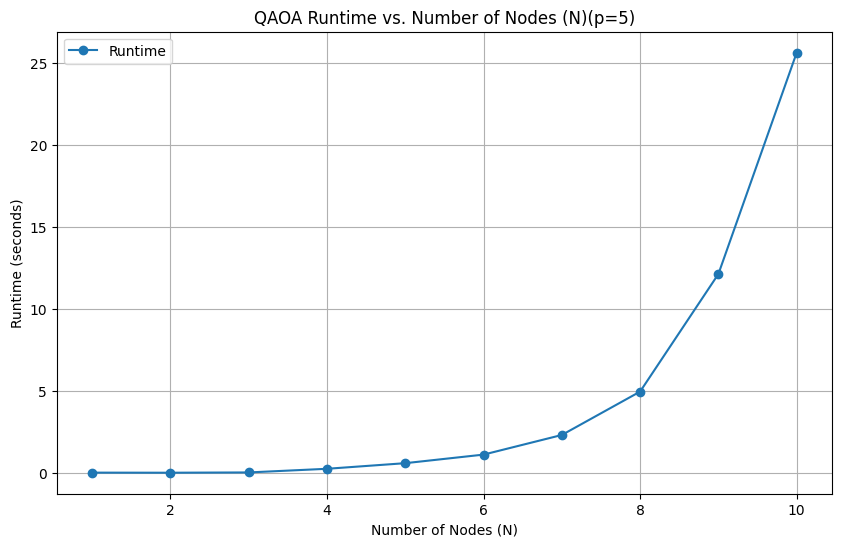

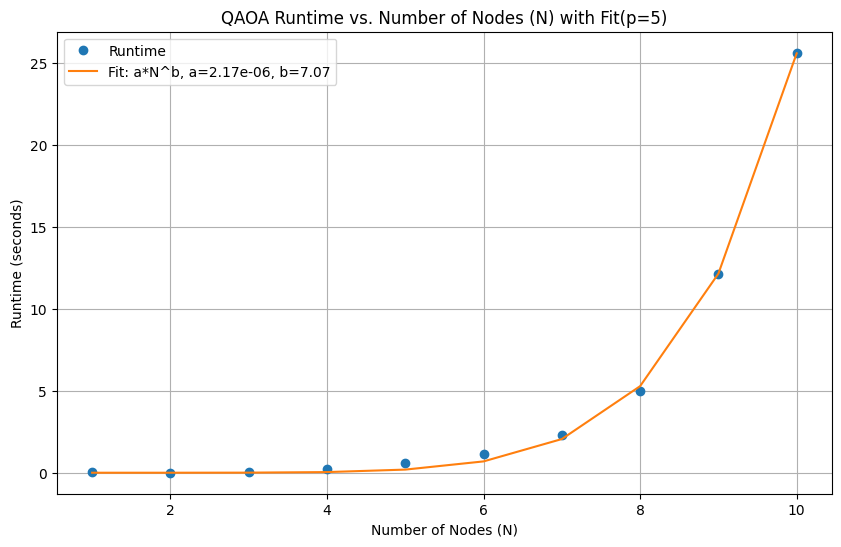

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 2.17e-06, b = 7.07


In [9]:
import typing
import qokit
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
import networkx as nx
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType

# numpy„ÅÆ„Ç∑„Éº„Éâ„ÇíË®≠ÂÆö
np.random.seed(0)

# QAOAÁî®„ÅÆÈñ¢Êï∞ÂÆöÁæ©
def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none

def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result

def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)

def get_state(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_statevector(result)

def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)

def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)

def get_overlap(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_overlap(result, preserve_state=True)

def inverse_objective_function(ising_model: TermsType, N: int, p: int, mixer: str, states: list[np.ndarray] | None) -> typing.Callable:
    def inverse_objective(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        simulator, result = get_simulator_and_result(N, ising_model, gamma, beta)
        expectation = get_expectation(N, ising_model, gamma, beta, simulator, result)

        if states is not None:
            states.append(get_state(N, ising_model, gamma, beta, simulator, result))

        return -expectation

    return inverse_objective

def QAOA_run(
    ising_model: TermsType,
    N: int,
    p: int,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    optimizer_method: str = 'COBYLA',
    optimizer_options: dict | None = None,
    mixer: str = "x",  # Using a different mixer is not yet supported
    states: list[np.ndarray] | None = None,
) -> dict:
    init_freq = np.hstack([init_gamma, init_beta]) 

    start_time = time.time()
    result = scipy.optimize.minimize(
        inverse_objective_function(ising_model, N, p, mixer, states), init_freq, method=optimizer_method, options=optimizer_options
    ) 
    end_time = time.time()

    gamma, beta = result.x[:p], result.x[p:]

    return {
        "gamma": gamma,
        "beta": beta,
        "state": get_state(N, ising_model, gamma, beta),
        "expectation": get_expectation(N, ising_model, gamma, beta),
        "overlap": get_overlap(N, ising_model, gamma, beta),
        "runtime": end_time - start_time,  # measured in seconds
        "num_QAOA_calls": result.nfev,
        "classical_opt_success": result.success,
        "scipy_opt_message": result.message
    }

# Max-Cut Ising Model„ÇíÁîüÊàê„Åô„ÇãÈñ¢Êï∞
def generate_maxcut_ising_terms(G: nx.Graph) -> TermsType:
    terms = []
    for i, j in G.edges():
        terms.append((-1, (i, j)))  # Max-Cut„ÅÆIsing„É¢„Éá„É´„ÅÆ„Åü„ÇÅ„ÅÆJij=-1
    return terms

# QAOAÂÆüË°å„Å®ÁµêÊûú„ÅÆ„Éó„É≠„ÉÉ„Éà
p = 5  # QAOA„ÅÆ„Çπ„ÉÜ„ÉÉ„ÉóÊï∞
num_samples = 10  # N„ÅÆÊúÄÂ§ßÂÄ§

# „É©„É≥„ÉÄ„É†„Ç∞„É©„Éï„ÅÆÁîüÊàê„Å®QAOA„ÅÆÂÆüË°å„ÄÅÂÆüË°åÊôÇÈñì„ÅÆË®òÈå≤
runtimes = []
Ns = range(1, num_samples + 1)

for N in Ns:
    G = nx.erdos_renyi_graph(N, 0.5, seed=0)
    ising_model = generate_maxcut_ising_terms(G)
    init_gamma, init_beta = np.random.rand(2, p)
    qaoa_result = QAOA_run(ising_model, N, p, init_gamma, init_beta, "COBYLA")
    runtimes.append(qaoa_result["runtime"])

# N„Å®ÂÆüË°åÊôÇÈñì„ÅÆ„Ç∞„É©„Éï„Çí„Éó„É≠„ÉÉ„Éà
plt.figure(figsize=(10, 6))
plt.plot(Ns, runtimes, 'o-', label="Runtime")
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Runtime (seconds)")
plt.title(f"QAOA Runtime vs. Number of Nodes (N)(p={p})")
plt.legend()
plt.grid(True)
plt.show()

# Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞
def fit_function(N, a, b):
    return a * N ** b

# „Éá„Éº„Çø„ÅÆ„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞
params, _ = scipy.optimize.curve_fit(fit_function, Ns, runtimes)

# „Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞ÁµêÊûú„ÅÆ„Éó„É≠„ÉÉ„Éà
plt.figure(figsize=(10, 6))
plt.plot(Ns, runtimes, 'o', label="Runtime")
plt.plot(Ns, fit_function(np.array(Ns), *params), '-', label=f"Fit: a*N^b, a={params[0]:.2e}, b={params[1]:.2f}")
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Runtime (seconds)")
plt.title(f"QAOA Runtime vs. Number of Nodes (N) with Fit(p={p})")
plt.legend()
plt.grid(True)
plt.show()

# „Éë„É©„É°„Éº„Çø„ÅÆË°®Á§∫
print(f"Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = {params[0]:.2e}, b = {params[1]:.2f}")


Let's create a graph showing the relationship between N (number of nodes) and QAOA runtime for each ùëù=1,‚Ä¶,10.

I'd like to present a similar approximation function and infer the runtime as N increases.

ÔºàÂêÑPÔºù1,‚Ä¶,10„Å´„Åä„Åë„Çã„ÄÅN„Å®QAOA„ÅÆRunTime„ÅÆÈñ¢‰øÇ„Å´Èñ¢„Åô„Çã„Ç∞„É©„Éï„Çí‰ΩúÊàê„Åó„Çà„ÅÜ„ÄÇ

‰∏ä„Å®ÂêåÊßò„Å´Ëøë‰ººÈñ¢Êï∞„ÇÇÊèêÁ§∫„Åó„Å¶„ÄÅN„ÅåÂ§ß„Åç„Åè„Å™„Åü„Å®„Åç„ÅÆRunTime„ÇíÈ°ûÊé®„Åß„Åç„Çã„Çà„ÅÜ„Å´„Åó„Åü„ÅÑ„ÄÇÔºâ

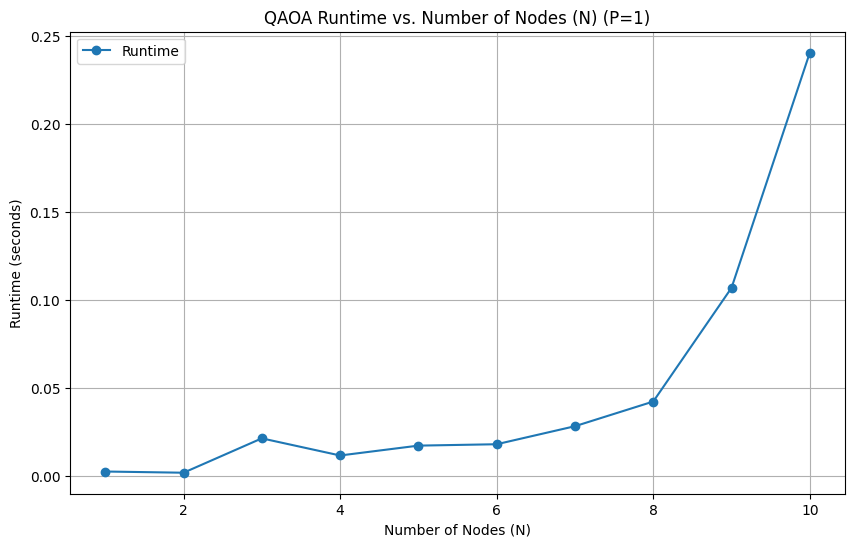

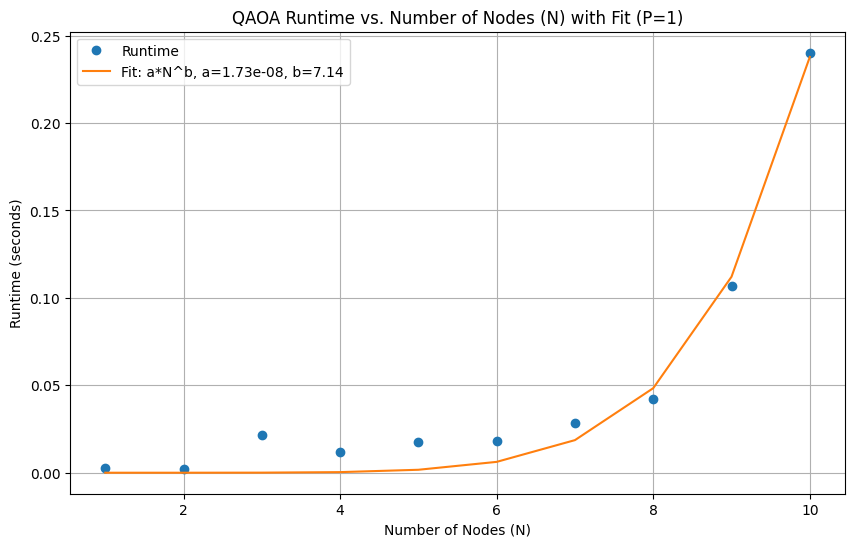

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 1.73e-08, b = 7.14


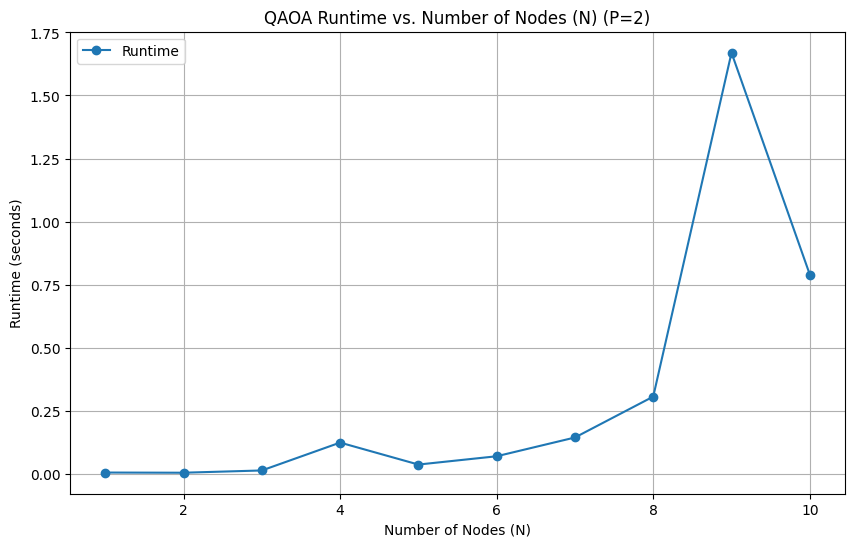

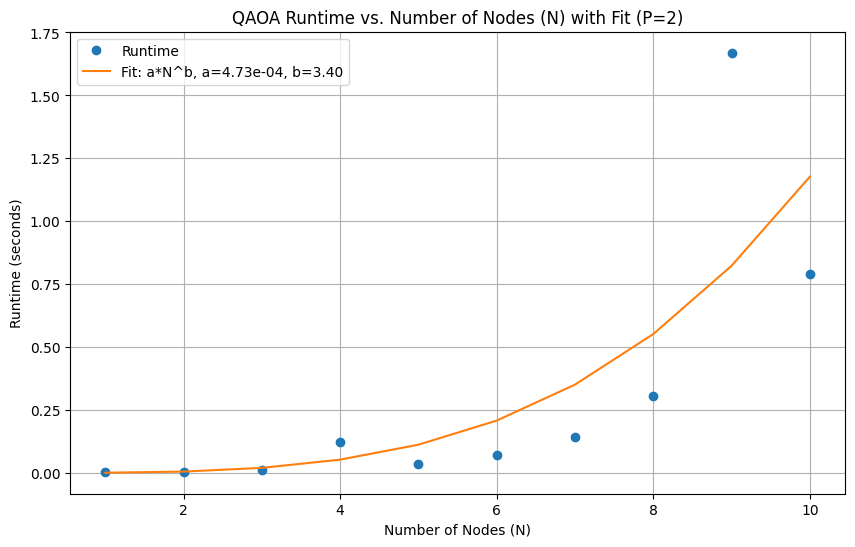

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 4.73e-04, b = 3.40


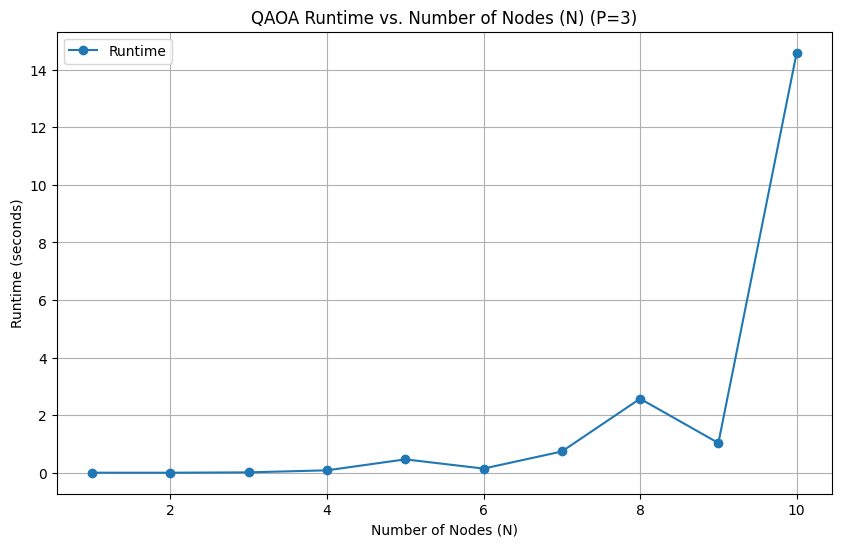

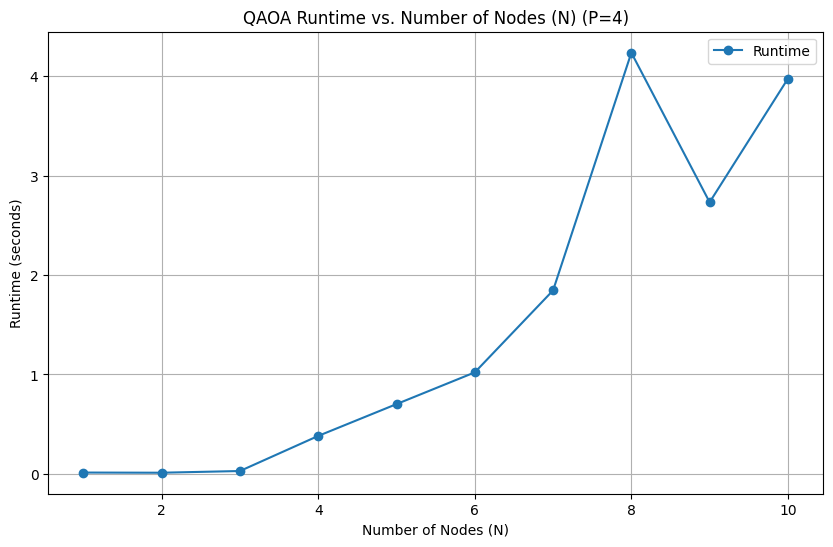

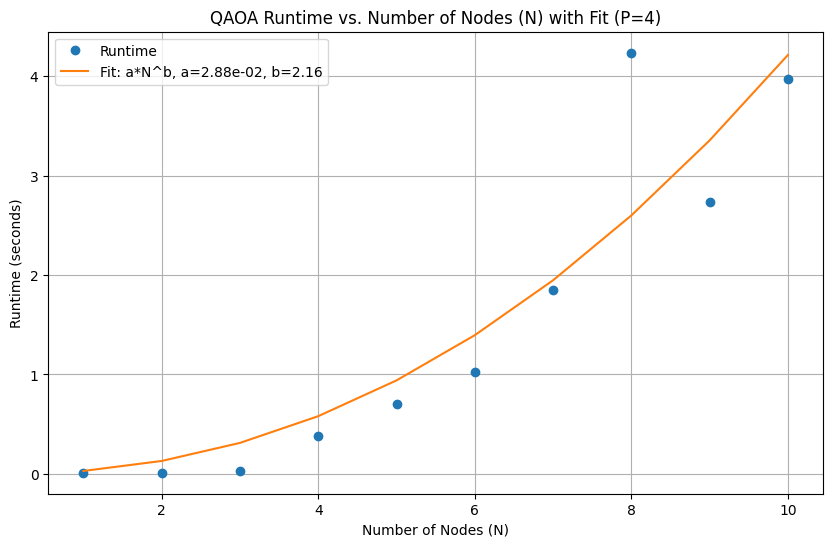

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 2.88e-02, b = 2.16


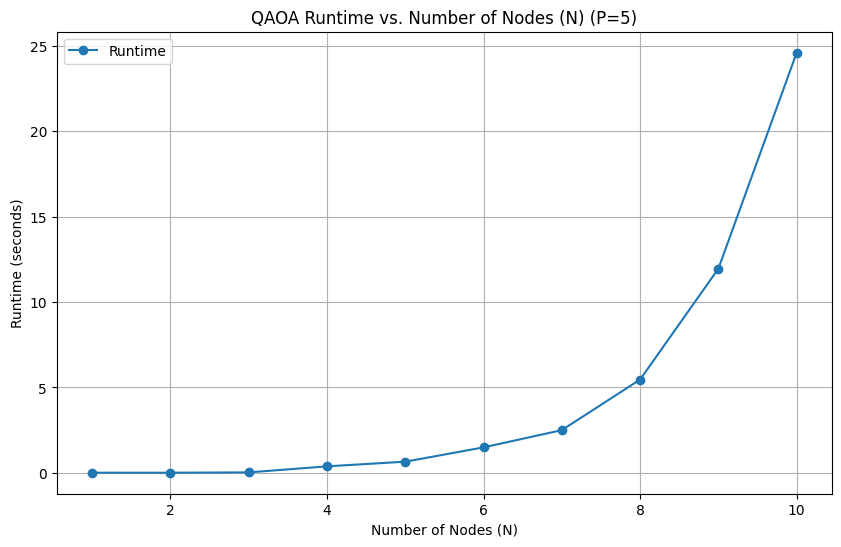

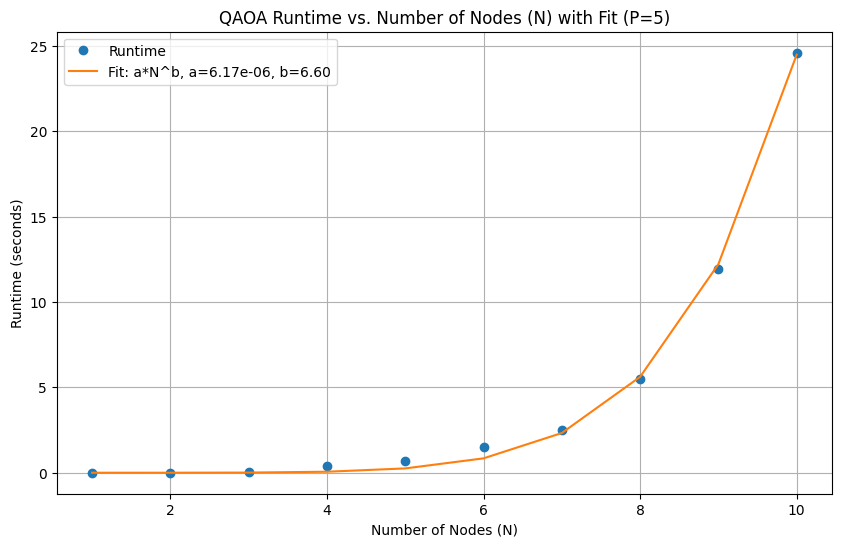

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 6.17e-06, b = 6.60


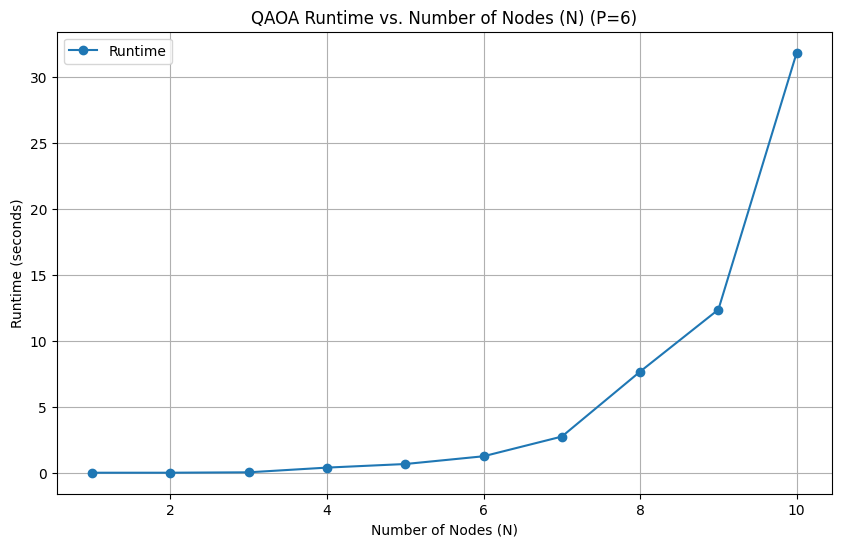

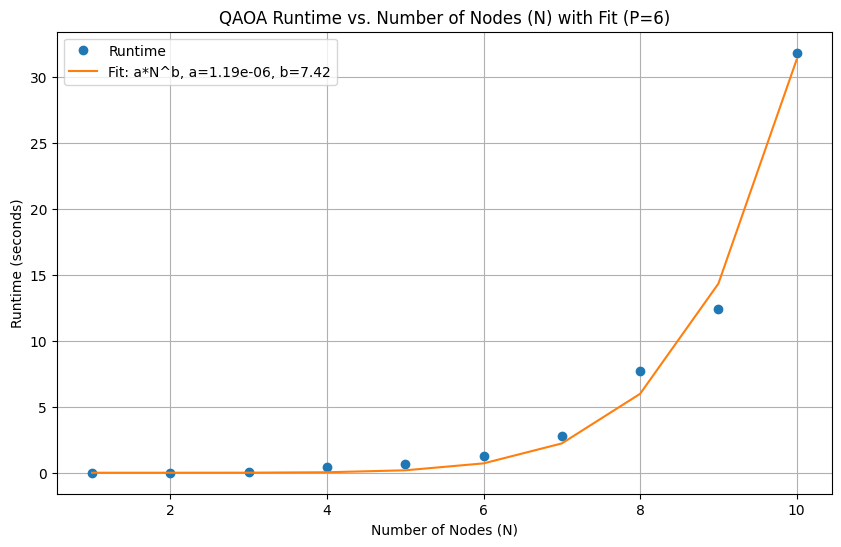

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 1.19e-06, b = 7.42


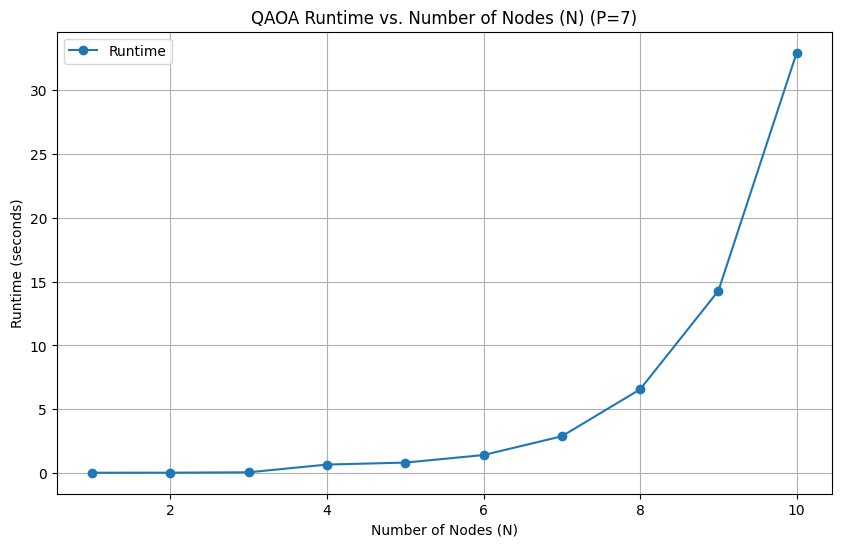

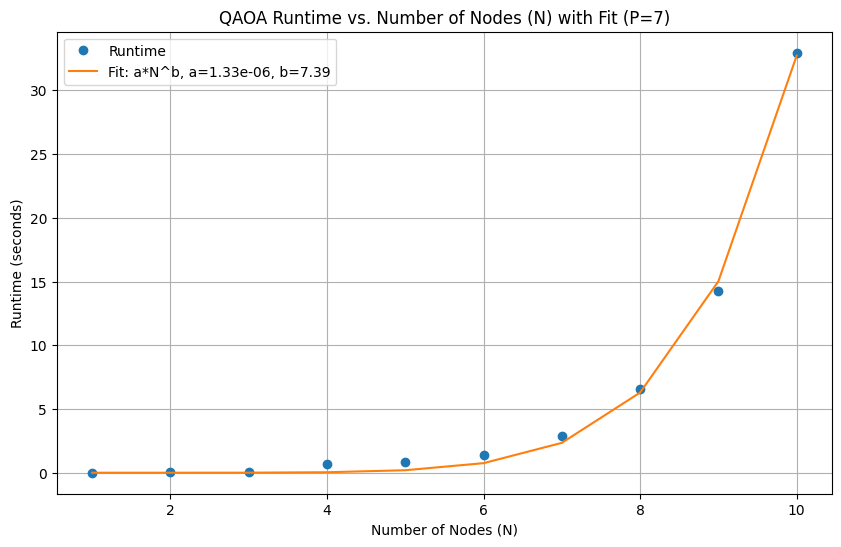

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 1.33e-06, b = 7.39


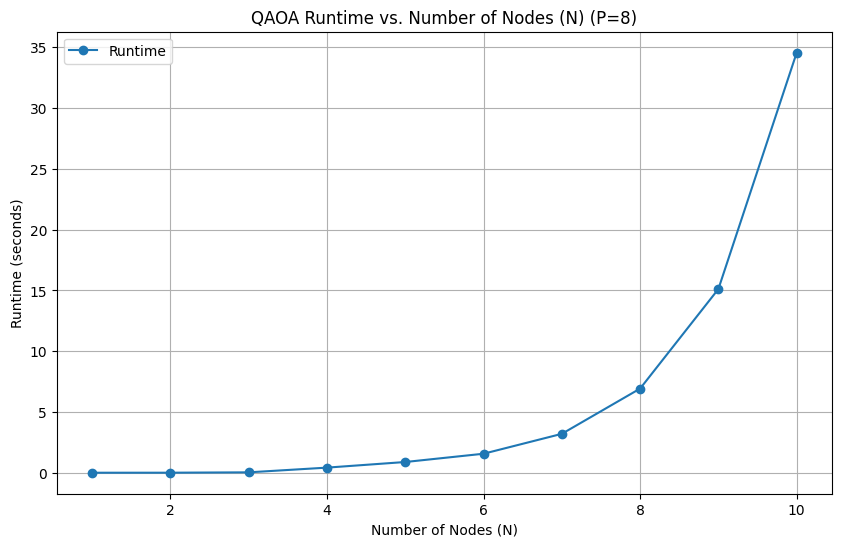

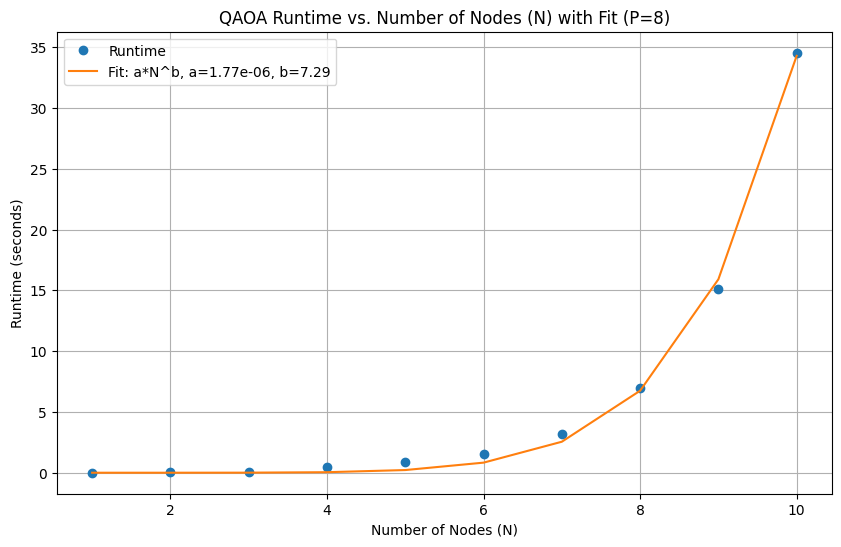

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 1.77e-06, b = 7.29


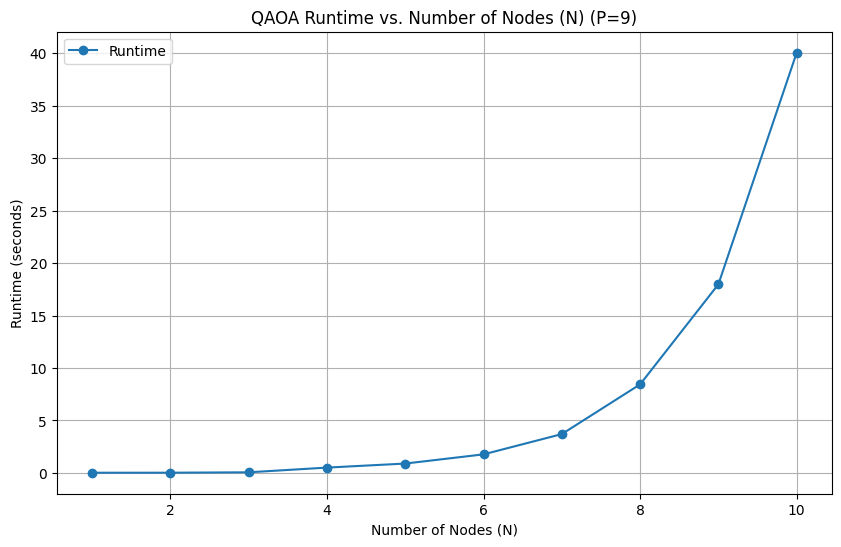

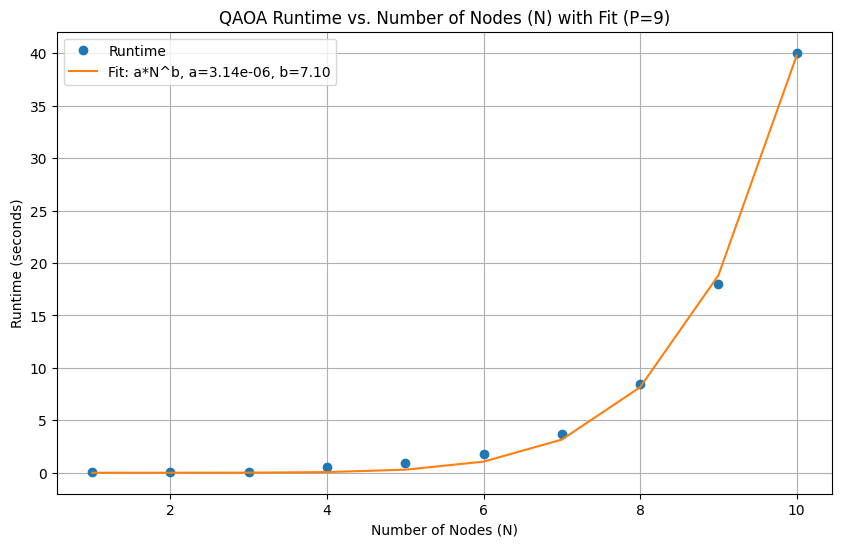

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 3.14e-06, b = 7.10


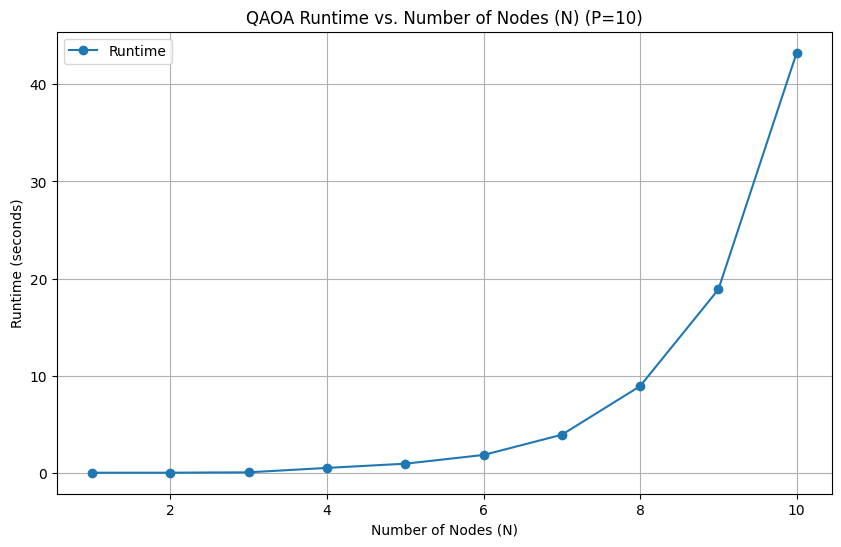

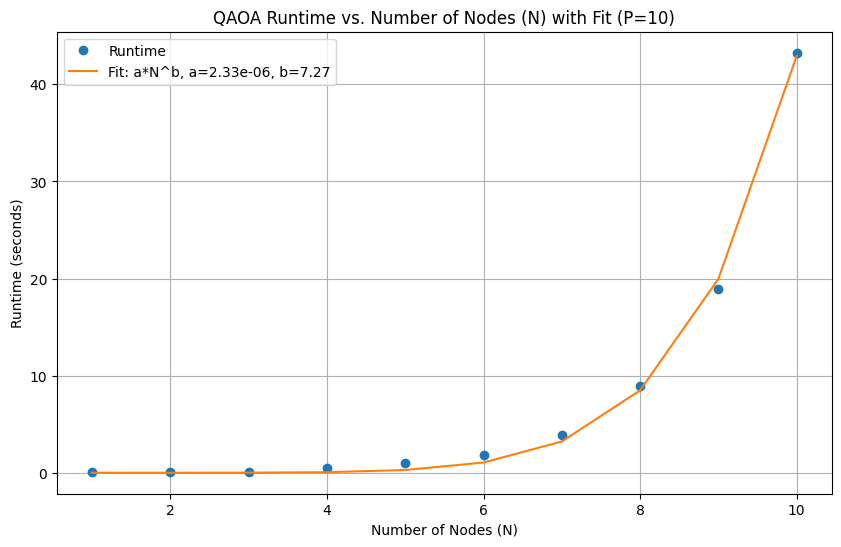

Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = 2.33e-06, b = 7.27


In [10]:
import typing
import qokit
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
import networkx as nx
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType
import os  # os„É¢„Ç∏„É•„Éº„É´„ÅÆ„Ç§„É≥„Éù„Éº„Éà„ÇíËøΩÂä†

# „É©„É≥„ÉÄ„É†„Ç∑„Éº„Éâ„ÅÆË®≠ÂÆö
np.random.seed(0)

# QAOAÁî®„ÅÆÈñ¢Êï∞ÂÆöÁæ©
def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none

def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result

def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)

def get_state(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_statevector(result)

def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)

def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)

def get_overlap(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_overlap(result, preserve_state=True)

def inverse_objective_function(ising_model: TermsType, N: int, p: int, mixer: str, states: list[np.ndarray] | None) -> typing.Callable:
    def inverse_objective(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        simulator, result = get_simulator_and_result(N, ising_model, gamma, beta)
        expectation = get_expectation(N, ising_model, gamma, beta, simulator, result)

        if states is not None:
            states.append(get_state(N, ising_model, gamma, beta, simulator, result))

        return -expectation

    return inverse_objective

def QAOA_run(
    ising_model: TermsType,
    N: int,
    p: int,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    optimizer_method: str = 'COBYLA',
    optimizer_options: dict | None = None,
    mixer: str = "x",  # Using a different mixer is not yet supported
    states: list[np.ndarray] | None = None,
) -> dict:
    init_freq = np.hstack([init_gamma, init_beta]) 

    start_time = time.time()
    result = scipy.optimize.minimize(
        inverse_objective_function(ising_model, N, p, mixer, states), init_freq, method=optimizer_method, options=optimizer_options
    ) 
    end_time = time.time()

    gamma, beta = result.x[:p], result.x[p:]

    return {
        "gamma": gamma,
        "beta": beta,
        "state": get_state(N, ising_model, gamma, beta),
        "expectation": get_expectation(N, ising_model, gamma, beta),
        "overlap": get_overlap(N, ising_model, gamma, beta),
        "runtime": end_time - start_time,  # measured in seconds
        "num_QAOA_calls": result.nfev,
        "classical_opt_success": result.success,
        "scipy_opt_message": result.message
    }

# Max-Cut Ising Model„ÇíÁîüÊàê„Åô„ÇãÈñ¢Êï∞
def generate_maxcut_ising_terms(G: nx.Graph) -> TermsType:
    terms = []
    for i, j in G.edges():
        terms.append((-1, (i, j)))  # Max-Cut„ÅÆIsing„É¢„Éá„É´„ÅÆ„Åü„ÇÅ„ÅÆJij=-1
    return terms

# Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞Èñ¢Êï∞
def fit_function(N, a, b):
    return a * N ** b

num_samples = 10  # N„ÅÆÊúÄÂ§ßÂÄ§
Ps = range(1, 11)  # QAOA„ÅÆ„Çπ„ÉÜ„ÉÉ„ÉóÊï∞„ÅÆÁØÑÂõ≤


# ‰øùÂ≠òÂÖà„Éá„Ç£„É¨„ÇØ„Éà„É™„ÇíÊåáÂÆö
save_dir = "data_for_graphs_Predict(1)"
os.makedirs(save_dir, exist_ok=True)  # „Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê„Åô„Çã

# P„Åî„Å®„Å´Âá¶ÁêÜ„ÇíË°å„ÅÜ„É´„Éº„Éó
for p in Ps:
    runtimes = []
    Ns = range(1, num_samples + 1)

    # „É©„É≥„ÉÄ„É†„Ç∞„É©„Éï„ÅÆÁîüÊàê„Å®QAOA„ÅÆÂÆüË°å„ÄÅÂÆüË°åÊôÇÈñì„ÅÆË®òÈå≤
    for N in Ns:
        G = nx.erdos_renyi_graph(N, 0.5, seed=0)
        ising_model = generate_maxcut_ising_terms(G)
        init_gamma, init_beta = np.random.rand(2, p)
        qaoa_result = QAOA_run(ising_model, N, p, init_gamma, init_beta, "COBYLA")
        runtimes.append(qaoa_result["runtime"])

    # N„Å®ÂÆüË°åÊôÇÈñì„ÅÆ„Ç∞„É©„Éï„Çí„Éó„É≠„ÉÉ„Éà
    plt.figure(figsize=(10, 6))
    plt.plot(Ns, runtimes, 'o-', label="Runtime")
    plt.xlabel("Number of Nodes (N)")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"QAOA Runtime vs. Number of Nodes (N) (P={p})")
    plt.legend()
    plt.grid(True)
    plt.show()
    np.save(f"data_for_graphs_Predict(1)/data_for_QAOA_RunTime_vs_N_p={p}_Ns_kanon",Ns)
    np.save(f"data_for_graphs_Predict(1)/data_for_QAOA_RunTime_vs_N_p={p}_runtimes_kanon",runtimes)

    # P=3„ÅÆÂ†¥Âêà„ÅÆ„ÅøËøë‰ººÈñ¢Êï∞„ÅÆ„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞„Çí„Åõ„Åö„ÄÅ‰ªñ„ÅÆP„ÅÆÂ†¥Âêà„ÅØ„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞„ÇíË°å„ÅÜ
    if p != 3:
        # „Éá„Éº„Çø„ÅÆ„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞
        params, _ = scipy.optimize.curve_fit(fit_function, Ns, runtimes)

        # „Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞ÁµêÊûú„ÅÆ„Éó„É≠„ÉÉ„Éà
        plt.figure(figsize=(10, 6))
        plt.plot(Ns, runtimes, 'o', label="Runtime")
        plt.plot(Ns, fit_function(np.array(Ns), *params), '-', label=f"Fit: a*N^b, a={params[0]:.2e}, b={params[1]:.2f}")
        plt.xlabel("Number of Nodes (N)")
        plt.ylabel("Runtime (seconds)")
        plt.title(f"QAOA Runtime vs. Number of Nodes (N) with Fit (P={p})")
        plt.legend()
        plt.grid(True)
        plt.show()
        np.save(f"data_for_graphs_Predict(1)/data_for_QAOA_RunTime_vs_N_with_Fit?p={p}_Ns_kanon",Ns)
        np.save(f"data_for_graphs_Predict(1)/data_for_QAOA_RunTime_vs_N_with_Fit_p={p}_runtimes_kanon",runtimes)
        np.save(f"data_for_graphs_Predict(1)/data_for_QAOA_RunTime_vs_N_with_Fit_p={p}_params_kanon",params)

        # „Éë„É©„É°„Éº„Çø„ÅÆË°®Á§∫
        print(f"Ëøë‰ººÈñ¢Êï∞„ÅÆ„Éë„É©„É°„Éº„Çø: a = {params[0]:.2e}, b = {params[1]:.2f}")

As N increases, the runtime tends to exhibit an exponential growth trend.

Increasing P causes the approximated value to approach an exponential form.

Furthermore, comparing cases of small and large P, larger P tends to show a trend where "runtime increases more significantly as N becomes larger."

N„ÅåÂ¢óÂä†„Åô„Çã„Å´„Å§„Çå„Å¶„ÄÅRunTimeÔºàÂÆüË°åÊôÇÈñìÔºâ„ÅØÊåáÊï∞Èñ¢Êï∞ÁöÑ„Å´Â¢óÂä†„Åô„ÇãÂÇæÂêë„Åå„ÅÇ„Çã„ÄÇ

P„ÇíÂ§ß„Åç„Åè„Åô„Çã„Å®„ÄÅËøë‰ºº„Åó„ÅüÂÄ§„ÅåÊåáÊï∞Èñ¢Êï∞„ÅÆÂΩ¢„Å´Ëøë„Å•„Åè„ÄÇ

„Åï„Çâ„Å´„ÅØ„ÄÅP„ÅåÂ∞è„Åï„ÅÑÊôÇ„Å®Â§ß„Åç„ÅÑÊôÇ„ÇíÊØîËºÉ„Åô„Çã„Å®„ÄÅP„ÅåÂ§ß„Åç„ÅÑ„Åª„ÅÜ„Åå„ÄåN„ÅåÂ§ß„Åç„Åè„Å™„Çã„Å´„Å§„Çå„Å¶RunTime„ÇÇ„Åï„Çâ„Å´Â§ß„Åç„ÅèÂ¢óÂä†„Åô„ÇãÂÇæÂêë„Äç„Åå„ÅÇ„Çã„ÄÇ